In [1]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout/')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from models.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from models.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from models.windowing_data import multivariate_data, prepare_data
from models.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features

from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


2024-02-13 09:32:44.031101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing data

In [2]:
data_folder = "/home/gperri-ext/master_thesis_tryout/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [3]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
# Separate features inputs
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]
df_total_load_f = df_total_load.iloc[:,:-1]

### Preparing I/O

In [5]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [42]:
# Choose dataset input
dataset_input = make_yearly_dataset(df_total_load_f, 2018, 2021)
print(dataset_input.tail(5))

                              PUN  PUN_d+1-7  PUN_d+1-14    GAS  GAS_d+1-7   
Time_data                                                                    
2021-12-31 19:00:00+00:00  219.14     266.60      391.64  78.22     101.42  \
2021-12-31 20:00:00+00:00  213.60     249.55      370.13  78.22     101.42   
2021-12-31 21:00:00+00:00  192.79     233.58      320.48  78.22     101.42   
2021-12-31 22:00:00+00:00  180.00     231.28      315.07  78.22     101.42   
2021-12-31 23:00:00+00:00  180.00     220.57      301.79  78.22     101.42   

                           Total_load_f  
Time_data                                
2021-12-31 19:00:00+00:00       38283.0  
2021-12-31 20:00:00+00:00       35750.0  
2021-12-31 21:00:00+00:00       33082.0  
2021-12-31 22:00:00+00:00       30609.0  
2021-12-31 23:00:00+00:00       28105.0  


In [43]:
target_size = 24
past_history = 24

step = 1


In [44]:
univariate = False

X, y = prepare_data(dataset_input, univariate=univariate)

In [59]:
# Divisione in training, validation e test set
train_index = int(len(dataset_input) * 0.6)
cv_index = train_index + int(len(dataset_input) * 0.05)
test_index = cv_index + int(len(dataset_input) * 0.35)

In [60]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X)
y_sc.fit(y)

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [61]:
X_train, y_train = multivariate_data(X_norm, y_norm,
                                     0, train_index, past_history, 
                                     target_size, step=step, single_step=False)

X_val, y_val = multivariate_data(X_norm, y_norm,
                                 train_index, cv_index, past_history, 
                                 target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                   cv_index, test_index, past_history, 
                                   target_size, step=step, single_step=False)


In [62]:
# y_test = y_test.reshape(-1, 1) # questo se single step = True
y_test_inv = y_sc.inverse_transform(y_test)

In [63]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

### Xgb train with "rndm" parameters

In [64]:
param = {'eta': 0.5, 'max_depth': 50, 
         'subsample': 0.9, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)

eval_list = [(dtrain, 'train'), (dval, 'eval')]

'''lambda [default=1, alias: reg_lambda]
L2 regularization term on weights (analogous to Ridge regression). 
This is used to handle the regularization part of XGBoost. 


alpha [default=0, alias: reg_alpha]
L1 regularization term on weights (analogous to Lasso regression).
'''

'lambda [default=1, alias: reg_lambda]\nL2 regularization term on weights (analogous to Ridge regression). \nThis is used to handle the regularization part of XGBoost. \n\n\nalpha [default=0, alias: reg_alpha]\nL1 regularization term on weights (analogous to Lasso regression).\n'

In [65]:
# for hyperparameters tuning see  Bayesian Optimization with HYPEROPT.
xgb_model = xgb.train(param, dtrain, 200, eval_list, early_stopping_rounds=10)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[09:48:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[0]	train-rmse:0.20177	eval-rmse:0.21551
[1]	train-rmse:0.10174	eval-rmse:0.10672
[2]	train-rmse:0.05234	eval-rmse:0.05221
[3]	train-rmse:0.02879	eval-rmse:0.02617
[4]	train-rmse:0.01864	eval-rmse:0.01543
[5]	train-rmse:0.01503	eval-rmse:0.01248
[6]	train-rmse:0.01399	eval-rmse:0.01210
[7]	train-rmse:0.01372	eval-rmse:0.01220
[8]	train-rmse:0.01364	eval-rmse:0.01233
[9]	train-rmse:0.01362	eval-rmse:0.01242
[10]	train-rmse:0.01362	eval-rmse:0.01247
[11]	train-rmse:0.01362	eval-rmse:0.01249
[12]	train-rmse:0.01361	eval-rmse:0.01250
[13]	train-rmse:0.01361	eval-rmse:0.01251
[14]	train-rmse:0.01361	eval-rmse:0.01251
[15]	train-rmse:0.01361	eval-rmse:0.01251


In [66]:
forecast = xgb_model.predict(dtest)
# xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = y_sc.inverse_transform(forecast)

In [67]:
print(y_test_inv.shape)
print(forecast.shape)
print(xgb_forecast_inv.shape)
print(f'DMatrix rows: {dtest.num_row()}, columns: {dtest.num_col()}')



(11893, 24)
(11893, 24)
(11893, 24)
DMatrix rows: 11893, columns: 144


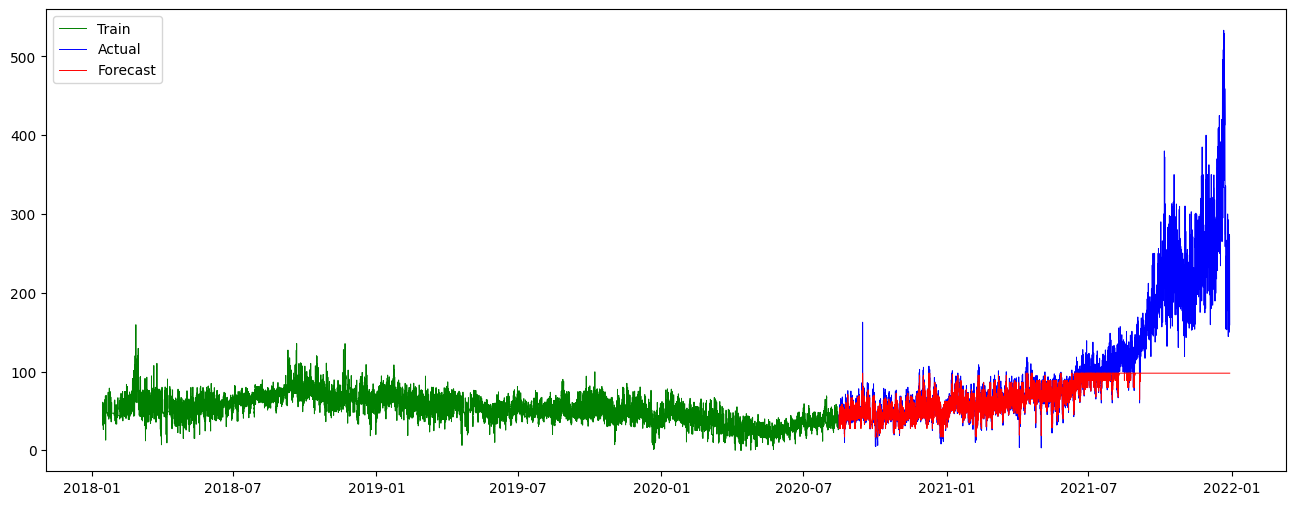

In [68]:
dates_train = dataset_input.index[:train_index]
dates_cv = dataset_input.index[train_index:cv_index]
dates_test = dataset_input.index[cv_index:]

# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(dates_train, y_sc.inverse_transform(y_train)[:,0], linewidth=0.7, color='g', label='Train')
plt.plot(dates_cv, y_sc.inverse_transform(y_val)[:,0], linewidth=0.7, color='g')
plt.plot(dates_test[:len(y_test)], y_test_inv[:,0], linewidth=0.7, label='Actual', color='b')
plt.plot(dates_test[:len(y_test)], xgb_forecast_inv[:,0], linewidth=0.7, color='r', label='Forecast')
plt.legend()
plt.show()

In [69]:
xgboost_table = evaluate_and_plot_timeseries(y_test_inv, xgb_forecast_inv, show_plot=False)


Min NMAE: 0.328 for Column: 0.0
Min RMSE: 67.111 for Column: 9.0
Min MAPE: 18.91 for Column: 0.0
Mean NMAE: 0.3677916666666667
Mean RMSE: 73.4105
Mean MAPE: 24.365791666666667


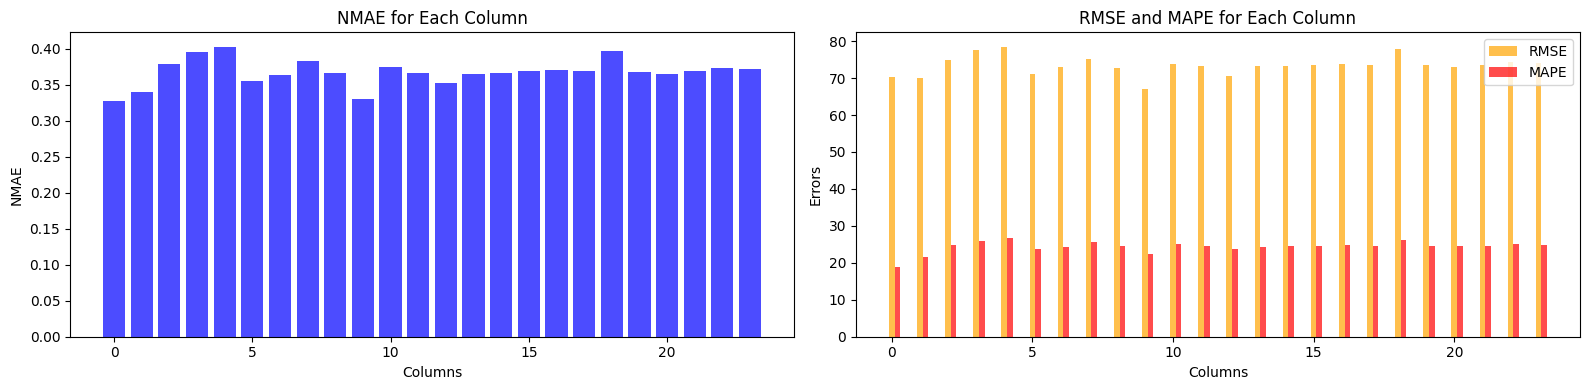

In [70]:
plot_error_metrics_barchart(xgboost_table)

### XGB regressor

In [40]:
from xgboost import XGBRegressor


xgb_model_sklearn = XGBRegressor(
    learning_rate=0.5,
    max_depth=50,
    subsample=0.9,
    colsample_bytree=0.95,
    alpha=0.1,
    reg_lambda=0.15,
    gamma=0.1,
    objective='reg:squarederror',  # 'reg:linear' è deprecato, 'reg:squarederror' è l'opzione attuale
    n_jobs=-1,
    n_estimators=200,
)

# Addestramento del modello
xgb_model_sklearn.fit(X_train_xgb, y_train, eval_metric='rmse', eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)], early_stopping_rounds=10)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.20517	validation_1-rmse:0.16282
[1]	validation_0-rmse:0.10346	validation_1-rmse:0.15252
[2]	validation_0-rmse:0.05323	validation_1-rmse:0.15076
[3]	validation_0-rmse:0.02930	validation_1-rmse:0.15062
[4]	validation_0-rmse:0.01897	validation_1-rmse:0.15119
[5]	validation_0-rmse:0.01519	validation_1-rmse:0.15192
[6]	validation_0-rmse:0.01396	validation_1-rmse:0.15157
[7]	validation_0-rmse:0.01364	validation_1-rmse:0.15181
[8]	validation_0-rmse:0.01355	validation_1-rmse:0.15169
[9]	validation_0-rmse:0.01351	validation_1-rmse:0.15188
[10]	validation_0-rmse:0.01351	validation_1-rmse:0.15196
[11]	validation_0-rmse:0.01348	validation_1-rmse:0.15193
[12]	validation_0-rmse:0.01346	validation_1-rmse:0.15192
[13]	validation_0-rmse:0.01345	validation_1-rmse:0.15178


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, ...)

In [41]:
# Predizione sui dati di test
xgb_forecast_sklearn = xgb_model_sklearn.predict(X_test_xgb)


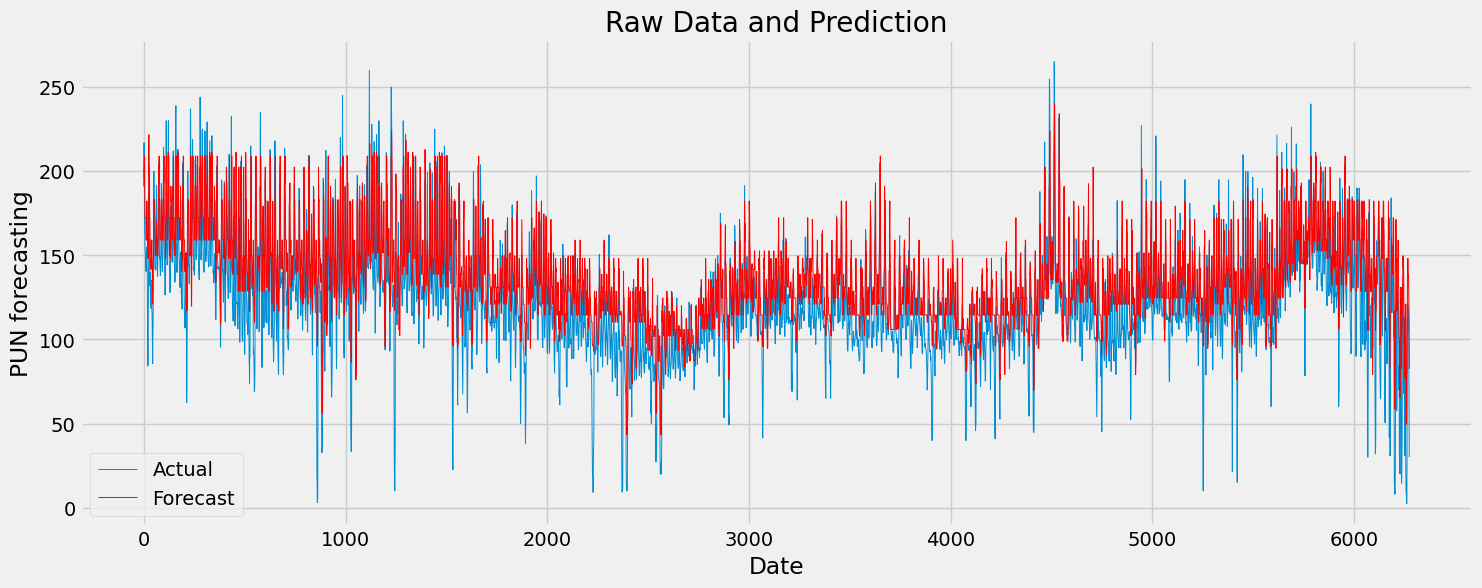

In [51]:
# Denormalizzazione delle previsioni
xgb_forecast_inv_sklearn = y_sc.inverse_transform(xgb_forecast_sklearn)

# Plot dei risultati
plt.figure(figsize=(16, 6))
plt.plot(y_test_inv[:,1], linewidth=0.7, label='Actual')
plt.plot(xgb_forecast_inv_sklearn[:,1], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()




In [52]:
evaluate_and_plot_timeseries(y_test_inv, xgb_forecast_inv_sklearn)


,Column,RMSE,MAPE,NMAE
0,0,19.169,18.927,0.136
1,1,25.383,25.444,0.173
2,2,26.257,25.897,0.171
3,3,27.760,27.665,0.182
4,4,26.677,26.770,0.176
5,5,24.952,25.345,0.163
6,6,27.720,27.431,0.182
7,7,26.872,26.782,0.175
8,8,27.231,27.229,0.180
9,9,27.165,27.042,0.178


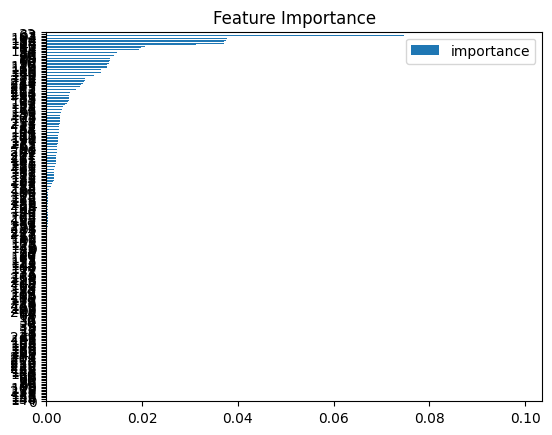

In [45]:
features_importance = pd.DataFrame(data=xgb_model_sklearn.feature_importances_,
            columns=['importance'])
features_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [56]:
import shap

In [66]:
import transformers

In [67]:
# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.25s/it]               


In [68]:
explainer = shap.DeepExplainer(xgb_model_sklearn, X_train_xgb)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: <class 'xgboost.sklearn.XGBRegressor'> is not currently a supported model type!

In [58]:
shap_values = explainer(X_test_xgb)

In [62]:
shap_values.shape

(6274, 240, 24)

In [60]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,0])

TypeError: only size-1 arrays can be converted to Python scalars

#### Xgb.regressor w/ features importance

XGBoost provides a way to examine the importance of each feature in the original dataset within the model.

It involves counting the number of times each feature is split on across all boosting trees in the model.

Then we visualize the result as a bar graph, with the features ordered according to how many times they appear.

XGBoost has a plot_importance() function that helps us to achieve this task.

Then we can visualize the features that has been given the highest important score among all the features.

Thus XGBoost provides us a way to do feature selection.


In [46]:
train_size = 0.8
test_size = 0.2

# Esegui la suddivisione
df_train, df_test = train_test_split(dataset_input, train_size=train_size, test_size=test_size, shuffle=False)

# "shuffle=False" garantisce che i dati rimangano nell'ordine originale

In [47]:
features = ['PUN_d+1-7', 'PUN_d+1-14', 'GAS', 'GAS_d+1-7',"Total_load_f", "Total_Load_d+1-7", 'GiornoSettimana', 'Ora', 'holiday']
target = 'PUN'

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [49]:
import xgboost as xgb
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.1)



reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:162.84336	validation_1-rmse:148.41171
[100]	validation_0-rmse:14.69524	validation_1-rmse:27.74365
[200]	validation_0-rmse:12.42156	validation_1-rmse:27.66764
[270]	validation_0-rmse:11.45041	validation_1-rmse:27.66196


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

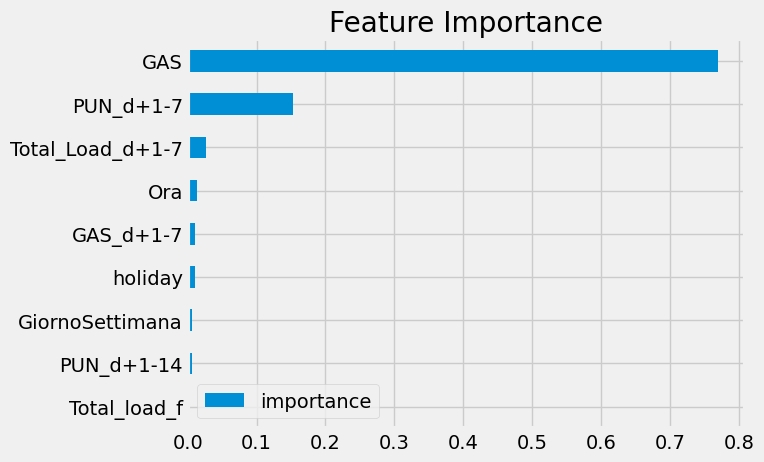

In [50]:
features_importance = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
features_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# df_2023.drop(columns='prediction', inplace=True)
# df_2021_22.drop(columns='prediction', inplace=True)


In [ ]:
df_test['prediction'] = reg.predict(X_test)
dataset_input = dataset_input.merge(df_test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
y_test.shape

(3442,)

In [ ]:
single_timeseries_evaluation_metrics_func(df_test['prediction'].values, y_test)

Evaluation metric results:-
MAE is : 52.284
RMSE is : 71.555
MAPE is : 16.796
NMAE is : 0.157


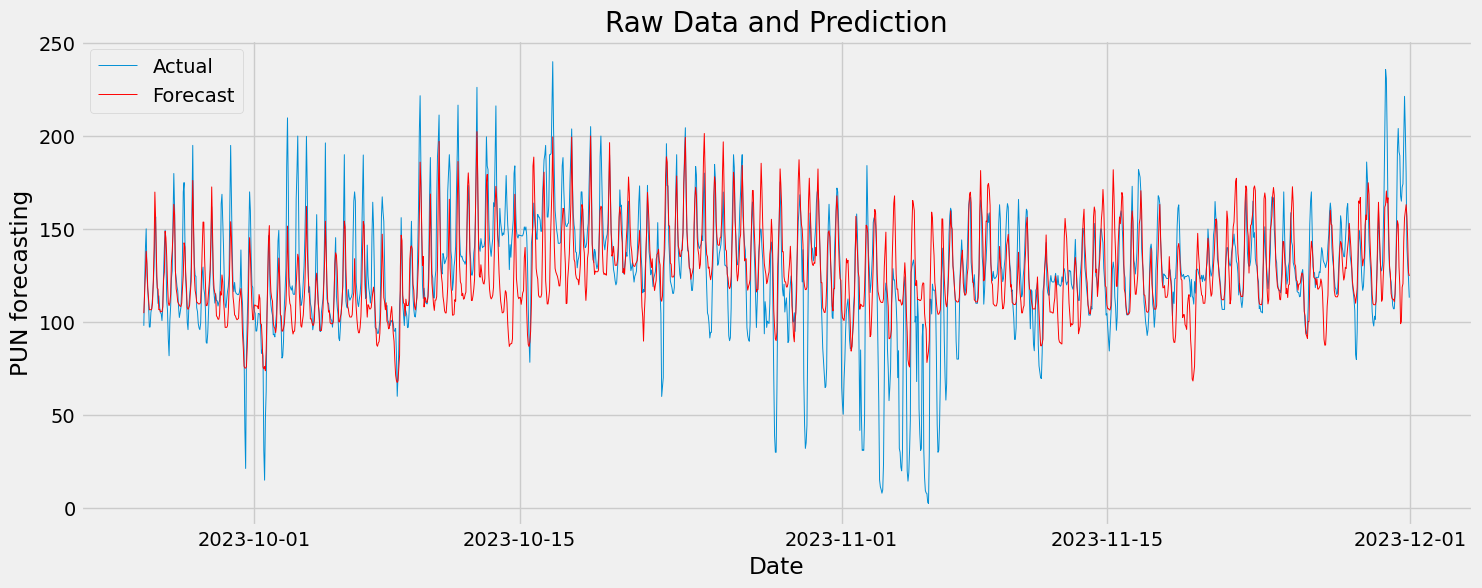

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df_test['PUN'], linewidth=0.7, label='Actual')
plt.plot(df_test['prediction'], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

